In [1]:
import pandas as pd
import numpy as np
import math

In [4]:
arbutusObsRaw = pd.read_csv("ArbutusObsevations.csv", sep = "\t")

/tmp/ipykernel_4012/2947188566.py:1: DtypeWarning: Columns (10,39,46) have mixed types. Specify dtype option on import or set low_memory=False.
  arbutusObsRaw = pd.read_csv("ArbutusObsevations.csv", sep = "\t")


In [5]:
arbutusObs = arbutusObsRaw[['species', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation']]

In [6]:
arbutusMenziesiiObs = arbutusObs[arbutusObs["species"] == "Arbutus menziesii"]

In [7]:
arbutusMenziesiiObs = arbutusMenziesiiObs[arbutusMenziesiiObs["decimalLatitude"].astype(int) >= 0]
arbutusMenziesiiObs = arbutusMenziesiiObs[arbutusMenziesiiObs["decimalLongitude"].astype(int) <= -10]

In [9]:
arbutusMenziesiiObs[:500].to_csv('TruncArbutusMenziesiiObs.csv', index=False)

In [10]:
arbutusMenziesiiObs.to_csv('arbutusMenziesiiObs.csv', index=False)

In [6]:
maxLat = np.max(arbutusMenziesiiObs["decimalLatitude"])
minLat = np.min(arbutusMenziesiiObs["decimalLatitude"])
maxLon = np.max(arbutusMenziesiiObs["decimalLongitude"])
minLon = np.min(arbutusMenziesiiObs["decimalLongitude"])

In [64]:
Nx = 50
Ny = 100
Lx = maxLon - minLon
Ly = maxLat - minLat
dx = float(Lx)/float(Nx)
dy = float(Ly)/float(Ny)
x = np.linspace(minLon, maxLon, Nx)
y = np.linspace(minLat, maxLat, Ny)

In [83]:
arbutusMenziesiiCounts = np.zeros((Ny,Nx))

In [85]:

for ind in arbutusMenziesiiObs.index:
    i = int(((arbutusMenziesiiObs['decimalLatitude'][ind] - minLat)/dy))
    j = int(((arbutusMenziesiiObs['decimalLongitude'][ind] - minLon)/dx))

    try:
        arbutusMenziesiiCounts[i][j] += 1
    except:
        if i == Ny:
            arbutusMenziesiiCounts[Ny - 1][j] += 1
        if j == Nx:
            arbutusMenziesiiCounts[i][Nx - 1] += 1

In [88]:
arbutusMenziesiiCounts

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [8]:
strHead = "{ \"type\":\"FeatureCollection\", \"features\":[ {\"type\":\"Feature\", \"properties\":{}, \"geometry\":{ \"coordinates\":["
coords= "[[-121.99100834896898,44.085339271440574],[-122.25426614942899,44.085339271440574],[-122.25426614942899,43.9070028454079],[-121.99100834896898,43.9070028454079],[-119.8100834896898,43.9570028454079],[-121.99100834896898,44.085339271440574]]"
strTail="],\"type\":\"Polygon\"}}]}"

In [11]:
jsonString = strHead + coords + strTail

with open("Output2.geojson", "w") as text_file:
    text_file.write(jsonString)

In [19]:
coordsNew = [[maxLon, maxLat], [maxLon,minLat], [minLon,minLat],[minLon,maxLat],[maxLon,maxLat]]

In [13]:
str(coordsNew)

'[[50.585645, -117.473198], [50.585645, -127.009742], [33.675249, -127.009742], [33.675249, -117.473198], [50.585645, -117.473198]]'

In [20]:
with open("FirstApprox4.geojson", "w") as text_file:
    text_file.write(strHead + str(coordsNew) + strTail)

In [47]:
with open("SecondApprox3.geojson", "w") as text_file:
    text_file.write(strHead + str(points[hull.vertices].tolist()) + strTail)


In [ ]:
points = rng.random((30, 2)) 

In [31]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
rng = np.random.default_rng()
points = np.array(menziePts)  # 30 random points in 2-D
hull = ConvexHull(points)


In [46]:
points[hull.vertices].tolist()

[[-117.473198, 33.675249],
 [-122.306104, 49.044096],
 [-122.588862, 49.517249],
 [-122.594518, 49.522626],
 [-125.036018, 50.257195],
 [-125.238743, 50.315119],
 [-126.918113, 50.57703],
 [-127.009742, 50.585645],
 [-124.285147, 40.324895],
 [-123.655713, 38.868994],
 [-121.849843, 36.282733],
 [-120.387121, 34.528197]]

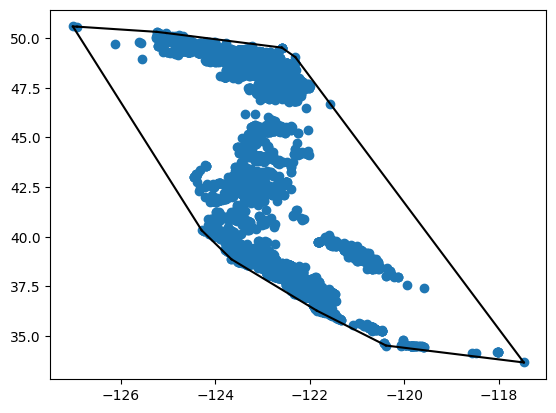

In [32]:
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [18]:
arbutusMenziesiiObs.head(10)

,species,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation
1,Arbutus menziesii,38.415645,-122.598695,10.0,NaN,NaN
2,Arbutus menziesii,38.018904,-122.657393,21.0,NaN,NaN
3,Arbutus menziesii,43.364802,-124.320687,9.0,NaN,NaN
4,Arbutus menziesii,37.998169,-122.709572,4.0,NaN,NaN
5,Arbutus menziesii,48.516700,-123.581855,2.0,NaN,NaN
6,Arbutus menziesii,40.324895,-124.285147,5.0,NaN,NaN
9,Arbutus menziesii,49.207220,-123.968545,159.0,NaN,NaN
11,Arbutus menziesii,47.620823,-122.755036,10.0,NaN,NaN
12,Arbutus menziesii,37.842638,-122.197263,10.0,NaN,NaN
13,Arbutus menziesii,48.319807,-123.544025,244.0,NaN,NaN


In [21]:
arbutusMenziesiiObs["decimalLongitude"].iloc(0)[1]

-122.657393

In [9]:
menziePts = [[arbutusMenziesiiObs["decimalLongitude"].iloc(0)[i],arbutusMenziesiiObs["decimalLatitude"].iloc(0)[i]] for i in range(len(arbutusMenziesiiObs["decimalLongitude"]))]

In [ ]:
#My first idea for computing a better hull: 

In [13]:
def minDist(l1,l2):
    M = 9999
    for pt1 in l1:
       for pt2 in l2:
           M = min(math.dist(pt1,pt2), M)
    return M

In [82]:
def myClustering(points):
    populations = []
    sortedPoints = sorted(points , key=lambda k: [k[1], k[0]])
    minPop = []
    minPop.append(sortedPoints[0])
    populations.append(minPop)
    maxDist = 1.9
    counter = 0
    maxMinDist = 0
    for pt in sortedPoints: 
        counter += 1
        print(counter)
        D = minDist([pt], populations[0])
        for pop in populations:
            D2 = minDist([pt], pop)
            maxMinDist = max(maxMinDist, D2)
            if D2 < D:
                minPop = pop
                D = D2
        if D2 < maxDist:
            minPop.append(pt)
        else: 
            populations.append([pt])
    print(maxMinDist)
        #compute the mininum distance to a population
 #If this minimum distance is bigger than max distance, make a new population. 
    return populations

In [90]:
def postProcessing(populations):
    maxDist = 1
    newPopulations = []
    for i in range(len(populations)):
        j = 0
        while j < len(newPopulations):
            if maxDist > minDist(populations[i], newPopulations[j]):
                newPopulations[j] = newPopulations[j] + populations[i]
                break
            j = j + 1
        if j == len(newPopulations):
            newPopulations.append(populations[i])
    return newPopulations


    # for each pop in populations
    #loop through the previous populations
    #If one is too close, combine the two and add it to the list
    #If none is close enough just add the population in question
    #return the new population

In [83]:
populations = myClustering(menziePts)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [91]:
newPopulations = postProcessing(populations)

In [92]:
len(newPopulations)

2

In [84]:
len(populations)

3

In [85]:
len(populations[0])

1628

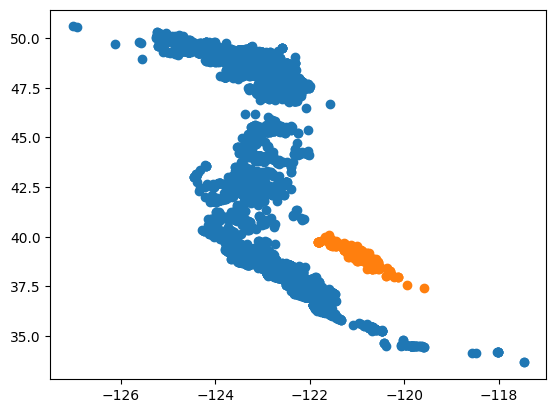

In [93]:
import matplotlib.pyplot as plt
for pop in newPopulations:
        plt.plot(np.array(pop)[:,0], np.array(pop)[:,1], 'o')

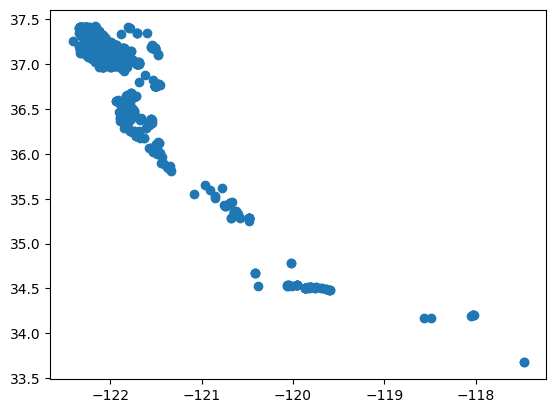

In [73]:
plt.plot(np.array(populations[0])[:,0], np.array(populations[0])[:,1], 'o')